---
title: 回聚类分析最佳实践
date: 2024-02-28 12:44:03
tags: [SPSS, R, 聚类]
mathjax: true
---

K 均值聚类（MacQueen 1967）是最常用的无监督机器学习算法之一，用于将给定数据集划分为一组 k 个组（即 k 个簇），其中 k 表示分析师预先指定的组数 。 它将对象分类为多个组，使得同一簇内的对象尽可能相似（即类内相似度高），而来自不同簇的对象尽可能不相似（即类间相似度低）。 在 k 均值聚类中，每个聚类由其中心（即质心）表示，该中心对应于分配给该聚类的点的平均值。

## 数学基础


这部分你看不懂并不影响本教程的继续阅读. 

k 均值聚类背后的基本思想包括定义聚类，以便最小化总的聚类内变异（称为总聚类内变异）。 有多种可用的 k 均值算法。 标准算法是 Hartigan-Wong 算法（Hartigan and Wong 1979），它将簇内总变异定义为项目与相应质心之间的欧氏距离平方和：

$$
W(C_k) = \sum\limits_{x_i \in C_k} (x_i - \mu_k)^2
$$

- $x_i$是类k中的样本点
- $\mu_k$是类k中所有样本的均值

我们的优化目标是让所有类内的距离平方和最小, 即下面的最小:

$$
tot.withinss = \sum\limits_{k=1}^k W(C_k) = \sum\limits_{k=1}^k \sum\limits_{x_i \in C_k} (x_i - \mu_k)^2
$$

## K-means 聚类最优 K值的确定

Kmeans 聚类需要研究者事先确定分类的个数, 但是如果你不知道分几类, 那么你可以参考下面的方法了

K-means 算法中K值的确定对于整个聚类非常重要,我们希望能从问卷数据自身出发去确定真实的聚类数，也就是对数据而言的最佳聚类数，而目前主流的确定聚类数k的方法有手肘法和轮廓系数法两类。我们将综合两个方法选出的1值，确定最终的聚类中心个数。但是要注意, 学术上有十几种方法帮助你确定分类个数, 我这里仅仅是列出了最常用的.

### 手肘法

手肘法是一种基于误差平方和（SSE）来确定k均值聚类中最优聚类数的方法。其核心思想是随着聚类数k的不断增大，每个类簇的聚合程度会不断提高，使得SSE逐渐减小。当k值小于真实聚类数时，随着k的增大，SSE的下降幅度较大；而当k到达真实聚类数后，再增加k的取值，SSE的下降幅度会迅速变小，然后随着k值的继续增大而趋于平缓。因此，SSE与k的关系曲线从陡峭变为平缓，呈现出“手肘型”的折线图，而“肘部”对应的k值即为最优聚类数。

这种方法之所以被称为“手肘法”，是因为在绘制SSE与k的关系图时，图形会呈现出一个类似手肘的形状，而最优聚类数就位于这个手肘的转折点处。这种方法直观易懂，能够帮助研究人员快速确定最优聚类数，从而更好地理解和分析数据。

需要注意的是，手肘法虽然是一种常用的确定最优聚类数的方法，但并非绝对准确。在实际应用中，还需要结合其他方法和指标来综合评估聚类效果，以获得更加准确和可靠的结果。

### 轮廓系数法 silhouette Coefficient

聚类分析中的轮廓系数法是一种评估聚类效果的指标，用于衡量聚类结果的紧密度和分离度。轮廓系数的取值范围在-1到1之间，越接近1表示聚类效果越好。该系数最早由Peter J. Rousseeuw在1986年提出，结合了内聚度和分离度两种因素。

轮廓系数的计算基于每个样本与其所属簇内的相似度以及与最近的其他簇间的不相似度。具体来说，对于每个样本，首先计算与同簇其他样本的平均距离（a），然后计算与最近簇内样本所在簇的平均距离（b）。轮廓系数si的计算公式为：si = (b - a) / max(a, b)。

根据轮廓系数的取值，可以判断聚类结果的合理性。当轮廓系数接近1时，表示样本聚类合理，簇内距离较小且簇间距离较大；当轮廓系数接近0时，表示样本聚类重叠；当轮廓系数接近-1时，表示样本被错误地分配到了相邻簇。

轮廓系数法可以用于聚类个数的选择。通过遍历不同的聚类数，计算对应的轮廓系数，选择轮廓系数最大时对应的聚类模型作为最优聚类数。这种方法在Kmeans聚类和层次聚类等算法中都有应用。

总之，轮廓系数法是一种有效的聚类效果评估指标，可以帮助研究人员更好地理解和分析聚类结果。

## 聚类分析的R语言实战

我们将使用数据集“USArrests”。 应按照 @ref(data-preparation-and-r-packages) 章节中的描述准备数据。 数据必须仅包含连续变量，因为 k 均值算法使用变量均值。 由于我们不希望 k 均值算法依赖于任意变量单位，因此我们首先使用 R 函数scale() 缩放数据，目的是将变量的均值设置为0, 标准差转换为1, 就是标准化的数据, 如下所示：

In [6]:
data("USArrests")      # Loading the data set
df <- scale(USArrests) # Scaling the data

# View the firt 3 rows of the data
head(df, n = 3)

,Murder,Assault,UrbanPop,Rape
Alabama,1.24256408,0.7828393,-0.5209066,-0.003416473
Alaska,0.50786248,1.1068225,-1.2117642,2.484202941
Arizona,0.07163341,1.4788032,0.9989801,1.042878388


In [7]:
class(df)

[1] "matrix" "array"

### 确定分类个数k

我们可以使用R中自带的kmeans函数来做聚类, 但是这个函数比较原始, 后来很多学者开发了更易于使用的 factoextra , 
它的结果更丰富, 并且提供了很好的可视化. 下面先安装它:

In [1]:
# install.packages("factoextra")
library("factoextra")

Warning message:
"package 'factoextra' was built under R version 4.3.3"


Loading required package: ggplot2

Welcome! Want to learn more? See two factoextra-related books at https://goo.gl/ve3WBa



手肘法确定最佳的分类个数:

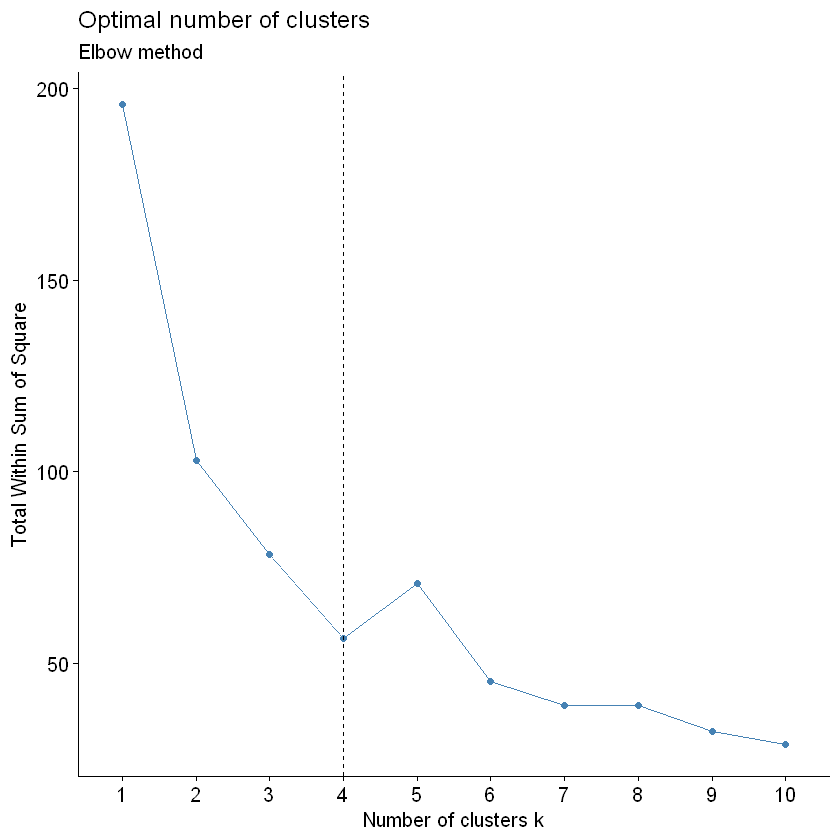

In [9]:
fviz_nbclust(df, kmeans, method = "wss") +
    geom_vline(xintercept = 4, linetype = 2)+
  labs(subtitle = "Elbow method")

根据手肘法, 最佳的分类应该是4类, 但是这是比较主观的判断, 如果你认为是5, 那么算你对!

下面我们再使用轮廓法:

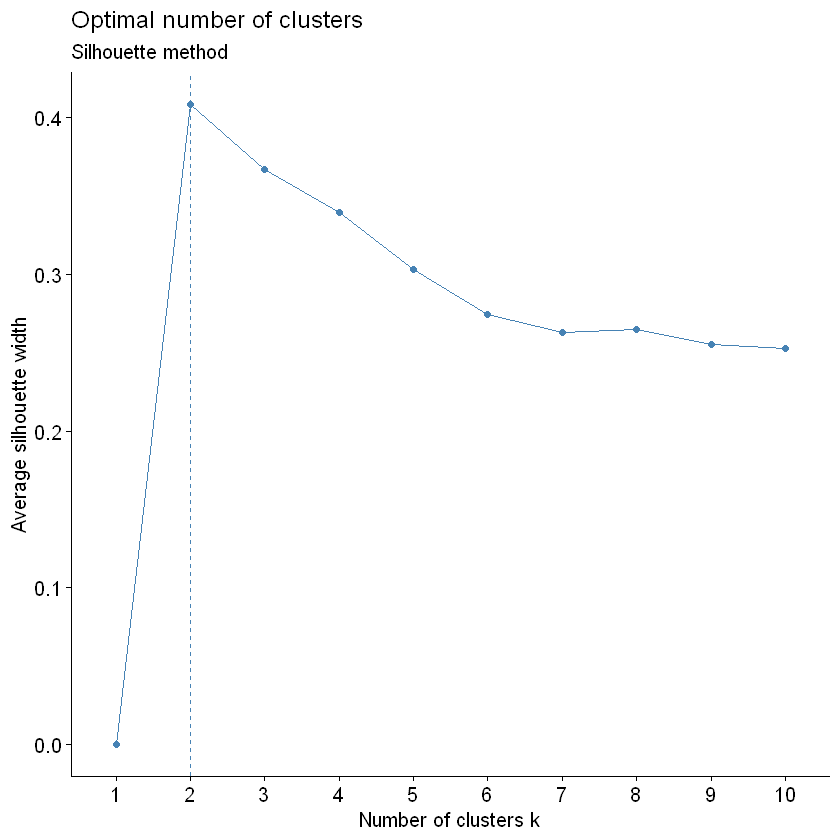

In [10]:
fviz_nbclust(df, kmeans, method = "silhouette", print.summary=FALSE)+
  labs(subtitle = "Silhouette method")

我们应当选择 silhouette 系数最大的分类, 那么2类似乎是最佳的, 我们还可以继续使用更多算法来寻找最佳分类个数,
但是目前限于篇幅, 我们先到此, 根据上面两个方法, 最佳分类可以选三类或者四类, 因为手肘法看到分类越多组内平方和越小, 但是silhouette系数是2类的时候最大, 
分类数越多silhouette系数越低, 但是三类和四类距离两类的silhouette系数其实差别不太大, 所以可以选择三类或者四类, 以下教程使用4类作为案例.

## 分类结果的可视化

下面我们将四个分类绘制出来, 以便大家可以归纳四种分类的特征.

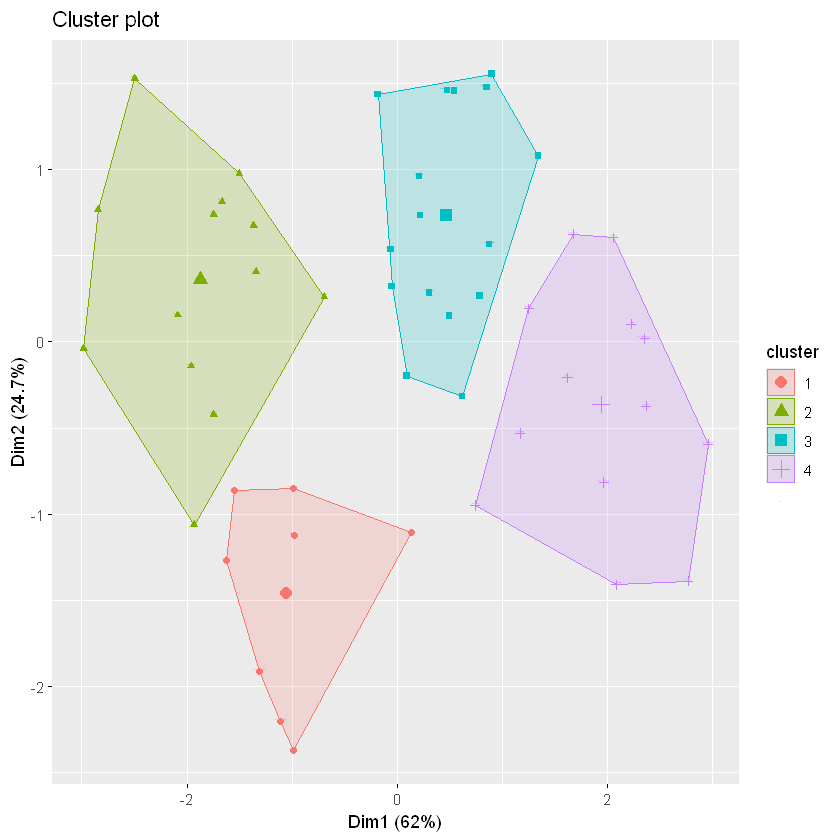

In [11]:
final <- kmeans(df, 4, nstart = 25)
fviz_cluster(final, data = df, labelsize =0)

我们可以通过下面的命令得到每个聚类的平均值:

In [12]:
final$centers

,Murder,Assault,UrbanPop,Rape
1,1.4118898,0.8743346,-0.8145211,0.01927104
2,0.6950701,1.0394414,0.7226370,1.27693964
3,-0.4894375,-0.3826001,0.5758298,-0.26165379
4,-0.9615407,-1.1066010,-0.9301069,-0.96676331


下面我们整理以下结果, 这个结果是我们论文常用的汇报的格式:

In [13]:
counts = as.data.frame(table(final$cluster))
counts$Percent = counts$Freq/sum(counts$Freq)
colnames(counts) = c("Cluster", "Frequency", "Percent")

enters = as.data.frame(final$centers)
counts$Murder = enters$Murder
counts$Assault = enters$Assault
counts$UrbanPop = enters$UrbanPop
counts$Rape = enters$Rape
counts

Cluster,Frequency,Percent,Murder,Assault,UrbanPop,Rape
<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,8,0.16,1.4118898,0.8743346,-0.8145211,0.01927104
2,13,0.26,0.6950701,1.0394414,0.7226370,1.27693964
3,16,0.32,-0.4894375,-0.3826001,0.5758298,-0.26165379
4,13,0.26,-0.9615407,-1.1066010,-0.9301069,-0.96676331
